In [120]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import xgboost as xgb
import os

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier
from sklearn.svm import SVR
from scipy.stats import randint, uniform
import xgboost


In [121]:
data_model = pd.read_csv("model/data_model.csv")

## Process weather data

In [122]:
weather_data = pd.read_csv("data/weather_data_leuven.csv")

In [123]:
import re
## rename the column
weather_data.columns = [re.sub(' \(.*\)', "", col) for col in weather_data.columns]

In [124]:
# extract from timestamp
weather_data["time"] = pd.to_datetime(weather_data['time'])
weather_data['date'] = weather_data['time'].dt.date
weather_data['hour'] = weather_data['time'].dt.hour
weather_data["month"] = weather_data["time"].dt.month
weather_data['weekday'] = weather_data['time'].dt.strftime('%a')

In [125]:
weather_data = weather_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()

C:\Users\svnel\AppData\Local\Temp\ipykernel_35440\2866054732.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weather_data = weather_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


In [126]:
# Dropping weathercode because signal should be contained in other data + excessive amount of dummies + unseen values
weather_data = weather_data.drop("weathercode", axis=1)

## Process airquality data



In [127]:
air_quality_data = pd.read_csv("data/air_quality_full.csv")

In [128]:
# Dropping index csv column
air_quality_data.drop(['Unnamed: 0'], inplace = True, axis  = 1)

In [129]:
# extract from timestamp
air_quality_data["dt"] = pd.to_datetime(air_quality_data['dt'])
air_quality_data['date'] = air_quality_data['dt'].dt.date
air_quality_data['hour'] = air_quality_data['dt'].dt.hour
air_quality_data["month"] = air_quality_data["dt"].dt.month
air_quality_data['weekday'] = air_quality_data['dt'].dt.strftime('%a')

In [130]:
air_quality_data = air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()

C:\Users\svnel\AppData\Local\Temp\ipykernel_35440\4239833663.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  air_quality_data = air_quality_data.groupby(["date", "hour", "month", "weekday"]).mean().reset_index()


## Processing file 40 data, merge all files

In [131]:
def merge_csv_files(directory_path):
    """
    Merges all CSV files in a directory into a single pandas DataFrame.
    
    Args:
    directory_path (str): The directory path containing the CSV files.
    
    Returns:
    merged_df (pandas.DataFrame): The merged pandas DataFrame of all CSV files in the directory.
    """
    dfs = []

    # loop through each file in the directory
    for file in os.listdir(directory_path):
        # check if the file is a CSV file
        if file.endswith('.csv'):
            file_path = os.path.join(directory_path, file)
            if directory_path.endswith("dataverse_file"):
                df = pd.read_csv(file_path, delimiter=",")
            else:
                df = pd.read_csv(file_path, delimiter=";")
            dfs.append(df)

    # concatenate all dataframes 
    merged_df = pd.concat(dfs, ignore_index=True)

    return merged_df


In [132]:
# Noise data
file40 = merge_csv_files('data/file_40')

In [133]:
### we would delete unit column because of same values
# drop all _unit columns
cols_to_drop  = [col for col in file40.columns if col.endswith('unit')]
file40.drop(cols_to_drop, axis=1, inplace=True)

# rename columns
file40.rename(columns={'description':'location',
                       "#object_id": "object_id"}, inplace=True)

In [134]:
# Convert the 'result_timestamp' column to a datetime data type
file40['result_timestamp'] = pd.to_datetime(file40['result_timestamp'])
file40['date'] = file40['result_timestamp'].dt.date
file40['hour'] = file40['result_timestamp'].dt.hour
file40["month"] = file40["result_timestamp"].dt.month
file40['weekday'] = file40['result_timestamp'].dt.strftime('%a')

In [135]:
file40 = file40.groupby(["object_id", "date", "hour", "month", "weekday"]).mean().reset_index()

C:\Users\svnel\AppData\Local\Temp\ipykernel_35440\918127979.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  file40 = file40.groupby(["object_id", "date", "hour", "month", "weekday"]).mean().reset_index()


In [136]:
data_model_v2 = file40.merge(air_quality_data, how = "inner",
                          left_on = ["date", "hour", "month", "weekday"],
                          right_on = ["date", "hour", "month", "weekday"])

In [137]:
data_model_v2 = data_model_v2.merge(weather_data, how = "inner",
                          left_on = ["date", "hour", "month", "weekday"],
                          right_on = ["date", "hour", "month", "weekday"])

In [138]:
## split train, test data
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(data_model_v2, test_size=0.2, random_state = 7)

## Process independent variable

In [139]:
target_variable = [col for col in train_df.columns if col.startswith("laf")]
target_variable

['laf005_per_hour',
 'laf01_per_hour',
 'laf05_per_hour',
 'laf10_per_hour',
 'laf25_per_hour',
 'laf50_per_hour',
 'laf75_per_hour',
 'laf90_per_hour',
 'laf95_per_hour',
 'laf98_per_hour',
 'laf99_per_hour',
 'laf995_per_hour']

In [140]:
y_train = train_df[target_variable]

In [141]:
y_val = val_df[target_variable]

In [142]:
X_train = train_df.drop(target_variable + ["date"], axis = 1)
X_val = val_df.drop(target_variable + ["date"], axis = 1)

In [143]:
one_hot_var = ["hour", "month", "weekday", "object_id"]
numerical_var = [col for col in X_train.columns if col not in one_hot_var]

In [144]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
t = ColumnTransformer(
    transformers = [
        ('OneHot', OneHotEncoder(handle_unknown='ignore'), one_hot_var),
        ('StandardScaler', StandardScaler(), numerical_var)
        
    ])

# fit the encoder
t.fit(X_train, y_train)


ColumnTransformer(transformers=[('OneHot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['hour', 'month', 'weekday', 'object_id']),
                                ('StandardScaler', StandardScaler(),
                                 ['pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2',
                                  'nh3', 'temperature_2m',
                                  'relativehumidity_2m', 'dewpoint_2m',
                                  'apparent_temperature', 'pressure_msl',
                                  'surface_pressure', 'precipitation', 'rain',
                                  'snowfall', 'cloudcover', 'cloudcover_low',
                                  'cloudcover_mid', 'cloudcover_high',
                                  'shortwave_radiation', 'direct_radiation',
                                  'diffuse_radiation',
                                  'direct_normal_irradiance', 'windspeed_10m',
                 

In [145]:
# Save encoder
import pickle
pickle.dump(t,open("model/encoder","wb"))

In [146]:
# create pandas DataFrame from dense matrix
X_train = pd.DataFrame(t.fit_transform(X_train), columns=t.get_feature_names_out())
X_val = pd.DataFrame(t.transform(X_val), columns=t.get_feature_names_out())

## Predict laf50

This is "examplatory", laf25/75 are run in the same way

In [147]:
import os.path
if os.path.isfile("model/laf50_dict"):
    print("Params have already been searched and saved, so instead we just load the file")
    params_dict = pickle.load(open("model/laf50_dict","rb"))
else:
    # Define the model parameters
    model_params = {
        'random_forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': randint(50, 100),
                'max_depth': randint(3, 50),
                'max_features': ['auto', 'sqrt'],
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10),
                'bootstrap': [True, False]
            }
        },
        'gradient_boosting': {
            'model': GradientBoostingRegressor(),
            'params': {
                'n_estimators': randint(50, 100),
                'learning_rate': uniform(0.01, 0.5),
                'max_depth': randint(1, 10),
                'min_samples_split': randint(2, 20),
                'min_samples_leaf': randint(1, 10)
            }
        },
        
        'xgboost': {
            'model': xgboost.XGBRegressor(),
            'params': {
                'n_estimators': randint(50, 100),
                'learning_rate': uniform(0.01, 0.5),
                'max_depth': randint(1, 10),
                'min_child_weight': randint(1, 10),
                'gamma': uniform(0, 1),
                'reg_alpha': uniform(0, 1),
                'reg_lambda': uniform(0, 1),
            }
        }
        
    }

    params_dict = {}

    # Loop through each model in model_params and run RandomizedSearchCV
    for model_name, model_info in model_params.items():
        print("Running RandomizedSearchCV for {}...".format(model_name))
        
        # Create a RandomizedSearchCV object for the current model
        model = model_info['model']
        param_dist = model_info['params']
        random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                        n_iter=10, cv=5, n_jobs=1, random_state=7)
        
        # Fit the RandomizedSearchCV object to the data
        random_search.fit(X_train, y_train["laf50_per_hour"])
        
        # Print the best parameters and score
        params_dict[model_name] = random_search.best_params_
        print("Best parameters for {}: ".format(model_name), random_search.best_params_)
        print("Best score for {}: ".format(model_name), random_search.best_score_)
        print("\n")

Params have already been searched and saved, so instead we just load the file


In [157]:
# Save optimal param dictionary
pickle.dump(params_dict,open("model/laf50_dict","wb"))

In [149]:
from sklearn.metrics import mean_absolute_error
gb_params = params_dict['gradient_boosting']

gb = GradientBoostingRegressor(**gb_params, random_state=7)

gb.fit(X_train, y_train["laf50_per_hour"])

train_preds = gb.predict(X_train)
val_preds = gb.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))


Train RMSE: 1.5910264458354786
Val RMSE: 2.4345394590473357
Train MAE: 1.1122357742340818
Val MAE: 1.6399656640092948


In [150]:
rf_params = params_dict['random_forest']

rf = RandomForestRegressor(**rf_params, random_state=7)

rf.fit(X_train, y_train["laf50_per_hour"])

train_preds = rf.predict(X_train)
val_preds = rf.predict(X_val)

print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 1.2752919994675074
Val RMSE: 2.5218920672648397
Train MAE: 0.8410768935471777
Val MAE: 1.6529127253665743


In [151]:
import xgboost

xgb_params = params_dict['xgboost']

xgb = xgboost.XGBRegressor(**xgb_params, random_state=7)

xgb.fit(X_train, y_train["laf50_per_hour"])

train_preds = xgb.predict(X_train)
val_preds = xgb.predict(X_val)


print("Train RMSE:", np.sqrt(mean_squared_error(train_preds, y_train["laf50_per_hour"])))
print("Val RMSE:", np.sqrt(mean_squared_error(val_preds, y_val["laf50_per_hour"])))
print("Train MAE:", mean_absolute_error(train_preds, y_train["laf50_per_hour"]))
print("Val MAE:", mean_absolute_error(val_preds, y_val["laf50_per_hour"]))

Train RMSE: 1.18945351883048
Val RMSE: 2.2361555984891868
Train MAE: 0.8379353141784668
Val MAE: 1.484125030497523


Text(0, 0.5, 'y val')

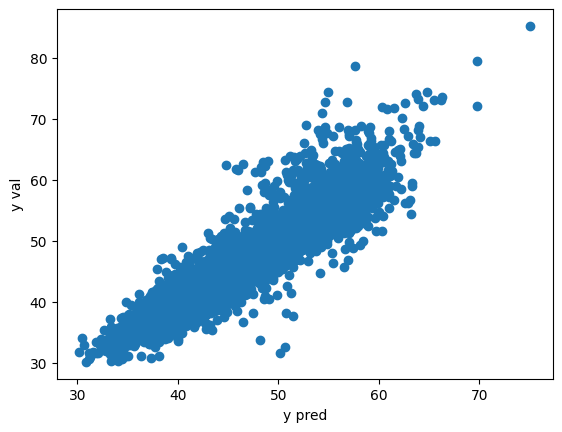

In [152]:
plt.scatter(val_preds, y_val["laf50_per_hour"])
plt.xlabel('y pred')
plt.ylabel('y val')

In [153]:
r2_score(val_preds, y_val["laf50_per_hour"])

0.8650905000296837

<BarContainer object of 30 artists>

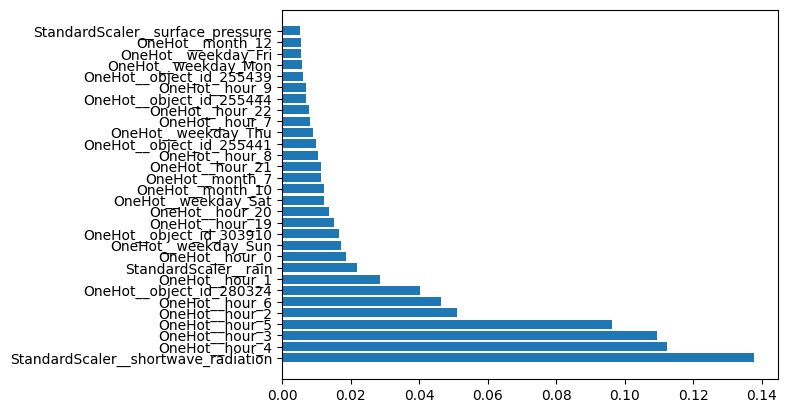

In [154]:
feature_importances = xgb.feature_importances_
sorted_idx = feature_importances.argsort()[::-1]
sorted_importances = feature_importances[sorted_idx[0:30]]
sorted_columns = list(X_train.columns[sorted_idx[0:30]])
plt.barh(sorted_columns, sorted_importances)

In [156]:
# Save models
import pickle 
pickle.dump(xgb, open("model/xgb_laf50","wb"))
# Not saving RF for now due to size restrictions
# pickle.dump(rf, open("model/rf_laf50","wb"))
pickle.dump(gb,open("model/gb_laf50","wb"))

## Predict Laf 25/75

In [158]:
import os.path
import pickle
targets = ['laf25_per_hour','laf75_per_hour']
model_params_dict = {}
for target in targets:
    if os.path.isfile(f"model/{target}_dict"):
        print("Params have already been searched and saved, so instead we just load the file")
        model_params_dict[target] = pickle.load(open(f"model/{target}_dict","rb"))
    else:
        # Define the model parameters
        model_params = {
            'random_forest': {
                'model': RandomForestRegressor(),
                'params': {
                    'n_estimators': randint(50, 100),
                    'max_depth': randint(3, 50),
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_split': randint(2, 20),
                    'min_samples_leaf': randint(1, 10),
                    'bootstrap': [True, False]
                }
            },
            'gradient_boosting': {
                'model': GradientBoostingRegressor(),
                'params': {
                    'n_estimators': randint(50, 100),
                    'learning_rate': uniform(0.01, 0.5),
                    'max_depth': randint(1, 10),
                    'min_samples_split': randint(2, 20),
                    'min_samples_leaf': randint(1, 10)
                }
            },
            
            'xgboost': {
                'model': xgboost.XGBRegressor(),
                'params': {
                    'n_estimators': randint(50, 100),
                    'learning_rate': uniform(0.01, 0.5),
                    'max_depth': randint(1, 10),
                    'min_child_weight': randint(1, 10),
                    'gamma': uniform(0, 1),
                    'reg_alpha': uniform(0, 1),
                    'reg_lambda': uniform(0, 1),
                }
            }
            
        }

        params_dict = {}

        # Loop through each model in model_params and run RandomizedSearchCV
        for model_name, model_info in model_params.items():
            print("Running RandomizedSearchCV for {}...".format(model_name))
            
            # Create a RandomizedSearchCV object for the current model
            model = model_info['model']
            param_dist = model_info['params']
            random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                            n_iter=10, cv=5, n_jobs=1, random_state=7)
            
            # Fit the RandomizedSearchCV object to the data
            random_search.fit(X_train, y_train[target])
            
            # Print the best parameters and score
            params_dict[model_name] = random_search.best_params_
            print("Best parameters for {}: ".format(model_name), random_search.best_params_)
            print("Best score for {}: ".format(model_name), random_search.best_score_)
            print("\n")
        
        model_params_dict[target] = params_dict
        pickle.dump(params_dict, open(f"model/{target}_dict","wb"))

Running RandomizedSearchCV for random_forest...
Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 85}
Best score for random_forest:  0.8554558984333323


Running RandomizedSearchCV for gradient_boosting...
Best parameters for gradient_boosting:  {'learning_rate': 0.4289589971546303, 'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 71}
Best score for gradient_boosting:  0.8651742418149604


Running RandomizedSearchCV for xgboost...
Best parameters for xgboost:  {'gamma': 0.13316944575925016, 'learning_rate': 0.2717062903368829, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 98, 'reg_alpha': 0.19335562339240953, 'reg_lambda': 0.100473971701034}
Best score for xgboost:  0.8798414901951368


Running RandomizedSearchCV for random_forest...
Best parameters for random_forest:  {'bootstrap': False, 'max_depth': 31, 'max_features': 'sqrt', 'min_sam